# **Instituto Tecnológico de Monterrey**

Maestría en Inteligencia Artificial Aplicada

Avance 3.- Baseline

Equipo 4

Integrantes:

Nancy Elena Estanislao Lizárraga - A01169334

Héctor Raúl Vázquez González - A00565542

Gustavo Rene Ramos Ojeda - A01793599

*************************************************************************

# **Prepraración**

Importación de Librerías

In [54]:
#Obtención de Datos
import pandas as pd
#Escalamiento
from sklearn.preprocessing import MinMaxScaler
import numpy as np
#Análisis de Características
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

#Modelos
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score

Obtención de la información

In [55]:
#Path del archivo CSV con la información con la que vamos a Trabajar
FilePath = 'https://raw.githubusercontent.com/gusrro/ProyectoIntegrador/main/dataF.csv'
#Creación del Dataframe usando el path del archivo
df_original = pd.read_csv(FilePath)

#Creamos una copia del dataframe original
#A partir de este punto se trabajará con esta copia
df_notnull = df_original.copy()
#Eliminamos las filas que contengan espacios nulos
df_notnull.dropna( axis=0, inplace=True)

Transformado de la información

In [56]:
#Declaramos las columnas a las que les aplicaremos la escalación
columns_to_scale = ['credited', 'debited']

#Se crea un nuevo dataframe para almacenar el resultado de la nueva inforamción
df_transformado = df_notnull.copy()
# Transformación logarítmica para las columnas seleccionadas
df_transformado[columns_to_scale] = np.sqrt(df_transformado[columns_to_scale])
df_transformado.describe()

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in sqrt
  result = func(self.values, **kwargs)


,day,mont,year,credited,debited,week_day,perc_remain
count,968.000000,968.000000,968.000000,968.000000,784.000000,968.000000,968.000000
mean,15.603306,6.632231,2021.341942,2681.474133,2815.756830,3.876033,75.134654
std,8.817327,3.539272,0.847050,1276.270887,704.703485,1.961660,2321.471128
min,1.000000,1.000000,2020.000000,1.697719,215.498300,1.000000,0.120655
25%,8.000000,3.000000,2021.000000,1908.183406,2621.515158,2.000000,0.204447
50%,16.000000,7.000000,2021.000000,3183.542889,2958.874230,4.000000,0.229106
75%,23.000000,10.000000,2022.000000,3549.836976,3221.450619,6.000000,0.420389
max,31.000000,12.000000,2023.000000,5879.142746,5069.030105,7.000000,72227.748430


Con la finalidad de reducir el número de parámetros de entrada, y por tanto, la complejidad de nuestro modelo. Crearemos una columna llamada "Day_of_year"; la cual indiracará el número de día con respecto del año.

Esta columna reemplazará las entrada de "day" y "mont".

In [57]:
#Vamos a definir un conjunto de funciones que cree una nueva columna
#Esta columna nos indicará número del día con respecto al año.
def get_dayNumber(day,month,year):

  result = 0

  bisiesto = False
  #Determinamos si el año es bisiesto
  if (not year % 4 and (year % 100 or not year % 400)):
    bisiesto = True

  #vamos a sumar el no. de dias
  #según el mes en el que se está.

  if month >= 1: #enero
    result = result + 0
  if month >= 2: #febrero
    result = result + 31
  if month >= 3: #marzo
    if bisiesto:
      result = result + 29
    else:
      result = result + 28
  if month >= 4: #abril
    result = result + 31
  if month >= 5: #mayo
    result = result + 30
  if month >= 6: #junio
    result = result + 31
  if month >= 7: #julio
    result = result + 30
  if month >= 8: #agosto
    result = result + 31
  if month >= 9: #septiembre
    result = result + 31
  if month >= 10: #octubre
    result = result + 30
  if month >= 11: #noviembre
    result = result + 31
  if month == 12: #diciembre
    result = result + 30

  #A esto le sumamos el no. de día en el mes
  result = result + day
  #Y regresamos el resultado
  return result

def add_DayNumber_Col (df):
  df.insert(8,"Day_of_Year",True)

  for row in df.index:
    df['Day_of_Year'][ row ] = get_dayNumber(df['day'][row],df['mont'][row],df['year'][row])
  return df

In [58]:
df_expadido = add_DayNumber_Col(df_transformado)

<ipython-input-57-4a6e4108d3cd>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day_of_Year'][ row ] = get_dayNumber(df['day'][row],df['mont'][row],df['year'][row])


In [59]:
#Aplicamos una correción al tipo de dato de la columna y
#verificamos que el cambio haya tomado efecto
df_expadido['Day_of_Year'] = df_expadido['Day_of_Year'].apply(pd.to_numeric)
df_expadido.dtypes

day              int64
mont             int64
year             int64
credited       float64
debited        float64
type            object
week_day         int64
perc_remain    float64
Day_of_Year      int64
dtype: object

Ahora, nuestra atención se centra en la columna de 'type', la cual nos indica si el día es feriado o es un día normal.

Para que la información contenida en esta columna tenga más sentido para el modelo, la traduciremos al tipo booleano. Ya que hasta este punto contiene valores alfabéticos, se creará una función que modifique estos valores.

In [60]:
def change_typeColumn(df):
  df['type'] = df['type'].map({'N': False, 'P': True})
  return df

In [61]:
df_expadido_modificado = change_typeColumn(df_expadido)
df_expadido_modificado['type'].describe()

count       968
unique        2
top       False
freq        904
Name: type, dtype: object

Con todo esto logrado, vamos a analizar la columna de 'credited'. Esta es la columna más importante para nuestro modelo. Como podemos ver en la siguietne celda, esta columna contiene valores en '0'.

Platicando con el representante de la institución, nos dimos cuenta de que esos valores representan los días en que la institución no tuvo operaciones, y por tanto, no tienen valor para nuestro caso. Ya que, si este modelo fuera a ser implementado en la producción de la institución este no sería consultado en esas fechas. Además, estos valores introducen ruido inecesario a nuestro modelo.

Por estos motivos, se ha acordado eliminar de nuestro caso de estudio estos valores. Para esto crearemos una función que haga esta tarea.

In [62]:
#Eliminaremos los datos con valores de 0
def remove_RowWith_Value0(df):
  for row in df.index:
    if df['credited'][row] == 1:
      df.drop(row, axis=0, inplace=True)
  return df

In [63]:
df_expandido_limpio = remove_RowWith_Value0(df_expadido_modificado)

Una vez que ya tenemos la información lista. Vamos a visualizar la matriz de correlación. en entregas anteriores ya hemos análizado y concluido que nuestra columna más importante es la de "credited", lo que nos llevará a hacer el análisis de correlación basándonos en esta columna.

In [64]:
df_expandido_limpio.describe()

,day,mont,year,credited,debited,week_day,perc_remain,Day_of_Year
count,968.000000,968.000000,968.000000,968.000000,784.000000,968.000000,968.000000,968.000000
mean,15.603306,6.632231,2021.341942,2681.474133,2815.756830,3.876033,75.134654,186.352273
std,8.817327,3.539272,0.847050,1276.270887,704.703485,1.961660,2321.471128,108.343458
min,1.000000,1.000000,2020.000000,1.697719,215.498300,1.000000,0.120655,1.000000
25%,8.000000,3.000000,2021.000000,1908.183406,2621.515158,2.000000,0.204447,87.750000
50%,16.000000,7.000000,2021.000000,3183.542889,2958.874230,4.000000,0.229106,192.000000
75%,23.000000,10.000000,2022.000000,3549.836976,3221.450619,6.000000,0.420389,280.000000
max,31.000000,12.000000,2023.000000,5879.142746,5069.030105,7.000000,72227.748430,366.000000


In [65]:
#Vamos a ver la correlación con la nueva información
#Se obtiene la matriz de correlación del Dataframe con el que se está trabajando
#(Se ha organizado conforme a la correlación con la columna credited)
MatrizDeCorrelación = df_expandido_limpio[['credited','debited','week_day','type','perc_remain','Day_of_Year','day','mont','year']].corr()
MatrizDeCorrelación

,credited,debited,week_day,type,perc_remain,Day_of_Year,day,mont,year
credited,1.000000,0.992831,-0.675828,0.096622,-0.067783,0.050979,0.048801,0.047061,0.014629
debited,0.992831,1.000000,-0.323014,0.116120,-0.833737,0.011817,0.175999,-0.002200,0.251164
week_day,-0.675828,-0.323014,1.000000,-0.034067,0.035002,-0.037922,-0.000215,-0.037704,0.097731
type,0.096622,0.116120,-0.034067,1.000000,-0.008560,0.018715,0.221435,0.000631,-0.009253
perc_remain,-0.067783,-0.833737,0.035002,-0.008560,1.000000,0.047690,-0.013147,0.048780,-0.050944
Day_of_Year,0.050979,0.011817,-0.037922,0.018715,0.047690,1.000000,0.108426,0.996665,-0.390434
day,0.048801,0.175999,-0.000215,0.221435,-0.013147,0.108426,1.000000,0.027265,-0.029588
mont,0.047061,-0.002200,-0.037704,0.000631,0.048780,0.996665,0.027265,1.000000,-0.388846
year,0.014629,0.251164,0.097731,-0.009253,-0.050944,-0.390434,-0.029588,-0.388846,1.000000


<Axes: >

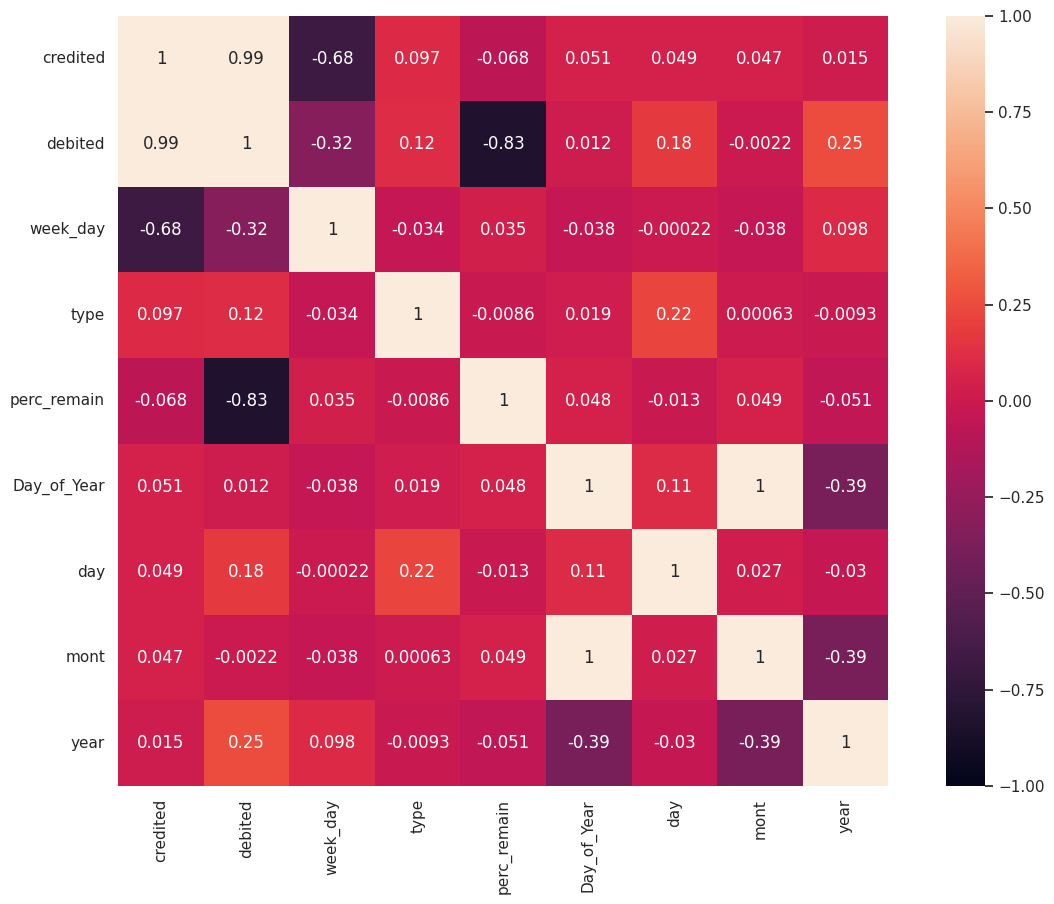

In [66]:
#Ahora visualicemos la información en una gráfica de mapa de calor
sns.set( rc= {'figure.figsize':(15, 10)})
sns.heatmap( MatrizDeCorrelación, vmin = -1, vmax = 1, square=True, annot = True)

Ya con la información de manera visual, podemos avanzar a la eliminación de características que se consideran que no deben/pueden ser admitidas como variables de entrada.

Características que se generaron en el futuro; las siguientes características se generaron cuando el día se terminó y por tanto, no pueden ser una entrada en nuestro modelo (se supone que será consultado al principio del día).
- debited.- Se refiere al monto que se utilizó durante el día.
- perc_remain.- Se refiere al porcentaje del monto que no se utilizó durante el día.

Caracterícticas con poca relación.- Estás características aportan poca información al modelo.
- day.- Se refiere al día del mes.
- mont.- Se refiere al número de mes.

Se ha decidido dejar el dato de "year" porque day y mont han sido reemplazados con la columna generada "Day_of_year" la cual tuvo una corelación mayor. Pero la columna 'year' no ha sido reemplazada, y tal vez aporta un poco de información al modelo.

In [67]:
df_limpio = df_expandido_limpio.copy()
df_limpio.columns

Index(['day', 'mont', 'year', 'credited', 'debited', 'type', 'week_day',
       'perc_remain', 'Day_of_Year'],
      dtype='object')

In [68]:
df_limpio.drop(['debited','perc_remain','day','mont'], axis=1, inplace=True)


In [69]:
df_limpio.dtypes

year             int64
credited       float64
type              bool
week_day         int64
Day_of_Year      int64
dtype: object

# **Los Sets de datos** (Train, Test y Val)

En esta sección crearemos los set para las pruebas. Veamos el set completo que tenemos para trabajar:


In [70]:
df_limpio.shape

(968, 5)

Ahora dividiremos los datos en sets:

In [71]:
#Dividiremos en X y Y
X = df_limpio[['year','type','week_day','Day_of_Year']].copy()
Y = df_limpio['credited'].copy()

In [72]:
X_train, X_test, y_train, y_test = train_test_split( X , Y , test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [73]:
print("Tamaño de X_train: "+ str(len(X_train)))
print("Tamaño de X_test: "+ str(len(X_test)))
print("Tamaño de X_val: "+ str(len(X_val)))
print("**********************************")
print("Tamaño de y_train: "+ str(len(y_train)))
print("Tamaño de y_test: "+ str(len(y_test)))
print("Tamaño de y_val: "+ str(len(y_val)))

Tamaño de X_train: 580
Tamaño de X_test: 194
Tamaño de X_val: 194
**********************************
Tamaño de y_train: 580
Tamaño de y_test: 194
Tamaño de y_val: 194


# **El algoritmo**

Primero crearemos un pipeline para la transformación de las columnas numéricas. Los pasos serán:
- un imputador
- un escalador

Para el imputador utilizaremos "la mediana", mientras que el escalador será in Minmax en el rango de 1 a 2.

Después, declararemos un transformador de columnas con nuestro pipeline. Las columnas que se pasarán a travéz de este paso serán las declaradas como "columns_to_process"; el resto de las columnas pasarán sin cambios.

In [74]:
#Columnas a tratar
columns_to_process = ['week_day','Day_of_Year','year']

# Transformaciones a factores numéricos de entrada:
num_pipeline = Pipeline(steps = [('impMediana', SimpleImputer(strategy='median')),
                                 ('escalaNum', MinMaxScaler(feature_range=(1,2)))])

# Conjuntamos las transformaciones numéricas y categóricas que se estarán aplicando a los datos de entrada:
columnasTransformer = ColumnTransformer(transformers = [('numpipe', num_pipeline, columns_to_process)],
                                        remainder='passthrough')

Ahora, creamos una función que contenga los modelos con los que vamos a probar. Lo haremos de esta forma en caso de que más adelante se decida agregar más modelos a este proceso.

El modelo que se utilizará es el de Regresion logística, Lasso, Ridge y Elastic Net, todos los modelos estarán con sus características por defecto.

In [75]:
def get_models():
  modelos = list()
  nombres = list()
  alpha_value = 30

  # LR - Regresión Logística:
  modelos.append(LinearRegression())
  nombres.append('LR')

  modelos.append((Lasso(alpha=alpha_value)))
  nombres.append('LASSO')

  modelos.append((Ridge(alpha=alpha_value)))
  nombres.append('RIDGE')

  modelos.append((ElasticNet(alpha=1, l1_ratio=.5)))
  nombres.append('EN')

  return modelos, nombres

In [76]:
modelos, nombres = get_models()  # cargamos los modelos a comparar
resultados = list() #Creamos la liste para los resultados

In [77]:
y_pred = []
for i in range(len(modelos)):

  pipeline = Pipeline(steps=[('ct',columnasTransformer),('m',modelos[i])])

  pipeline.fit(X_train, y_train)
  scores = pipeline.score(X_test,y_test)

  y_pred.append(pipeline.predict(X_test))


  resultados.append(scores)
  print('>> %s: %.3f ' % (nombres[i], np.mean(scores)))

>> LR: 0.373 
>> LASSO: 0.384 
>> RIDGE: 0.371 
>> EN: 0.142 


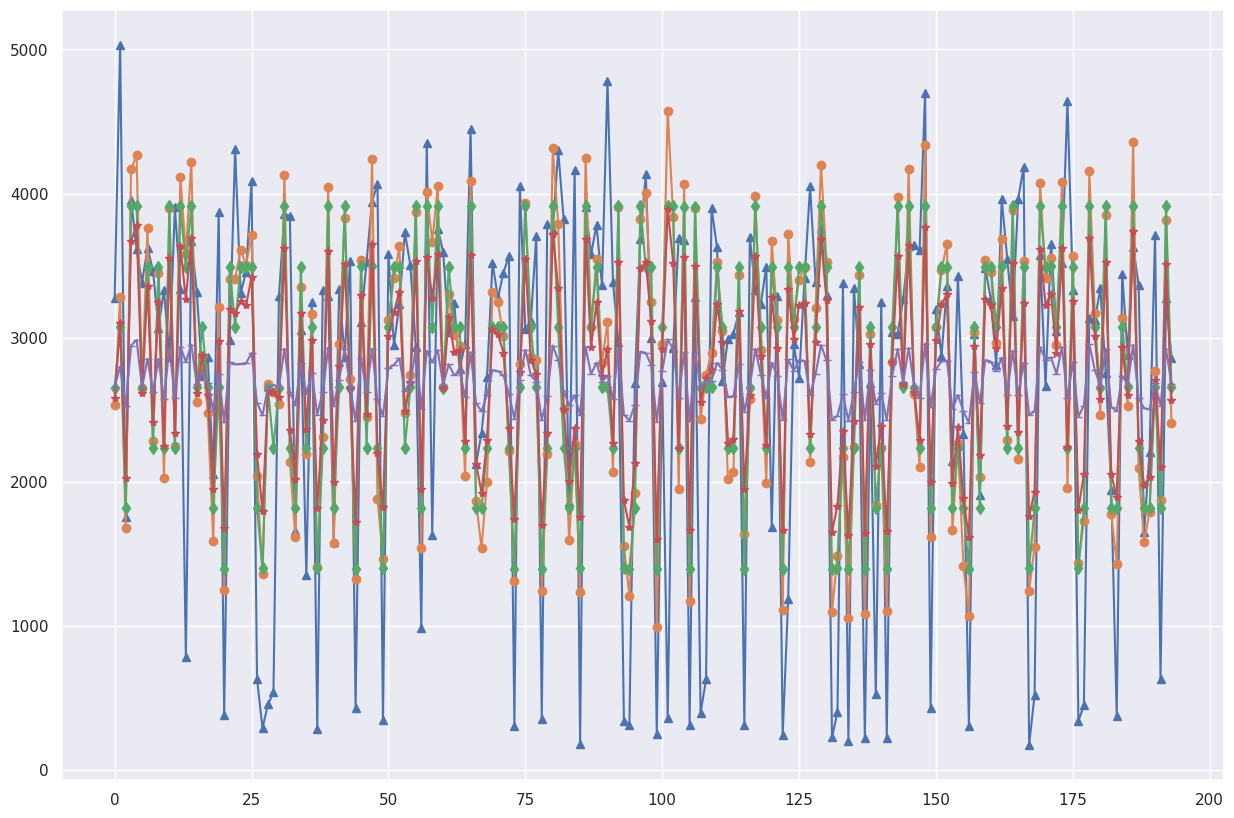

In [85]:
x1 = np.arange(0,len(y_test))

plt.plot(x1, np.ravel(y_test), marker='^', label='Test')
plt.plot(x1, np.ravel(y_pred[0]), marker='o', label='LR')
plt.plot(x1, np.ravel(y_pred[1]), marker='d', label='LASSO')
plt.plot(x1, np.ravel(y_pred[2]), marker='*', label='RIDGE')
plt.plot(x1, np.ravel(y_pred[3]), marker='_', label='EN')

# **Preguntas**

**¿Qué algoritmo se puede utilizar como baseline para predecir las variables objetivo?**

El equipo ha decidido comenzar a implementar un conjunto de modelos de preddicción lineal como Baseline para predecir el comportamiento de la gráfica.

Este conjunto de modelos está formado por los modelos de "LinearRegression", "Lasso", "Ridge" y "Elastic-Net".

**¿Se puede determinar la importancia de las características para el modelo generado? Recuerden que incluir características irrelevantes puede afectar negativamente el rendimiento del modelo y aumentar la complejidad sin beneficios sustanciales.**

Estamos tratando de determinar la importancia de las características mediante un estudio de PCA (el cual se vió en netregas pasadas), en conjunto con la correlación entre las características.

Además, como se muestra durante el proceso, también se tuvo que eliminar características que se generaron en el futuro (una vez que ya se tenían los resultados reales).

**¿El modelo está sub/sobreajustando los datos de entrenamiento?**

Debido al desempeño que mostraron los modelos, El equipo ha observado que los modelos, a pesar de tener un score bajo, se han tratado de adaptar bien a la gráfica real.

Se ha concluido que el problema está en que la información con la que se han alimentado los modelos necesita un mejor pre-procesamiento. La información con la que se ha trabajado cuenta todavía con muchos "outliers" lo que dificulta a los modelos tener un buen score de desempeño.

Además, si un modelo mostrara un buen desempeño con la información en el estado actual, podríamos concluir fácilmente que dichos modelos estarían sobre-entrenados. Por el momento, no es fácil tomar una desición.

**¿Cuál es la métrica adecuada para este problema de negocio?**

La métrica que se está utlizando hasta ahora es la de R2, la cual es la que se utiliza por defecto en modelos de regresión lineal.

Esta métrica estadística mide la proporción de la varianza en la variable dependiente que es predecible, a partir de la variable independiente.


**¿Cuál debería ser el desempeño mínimo a obtener?**

Aunqúe a todo el mundo nos gustaría un 100% de "exactitud" en nuestros modelos. La realidad es que un modelo con un desempeño de 70% es considerado bueno en un escenario real.

El equipo ha obtenido un desempeño entre el 14% y 38% con el score de r2 con los modelos actuales. En entregas futuras nos gustaría mejorar estas cifras con un mejor pre-procesamiento de la información y buscando óptimizar los parámetros del modelo. También nos gustaría probar con otro tipo de modelos para comparar desempeños.